In [ ]:
import torch
import gpytorch as gp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import yfinance as yf
import pandas_datareader.data as web

from typing import Tuple

import datetime

from utility import get_closing_price_from_yfinance, get_effr_from_nyfed, get_daily_excess_return

[*********************100%***********************]  1 of 1 completed


''

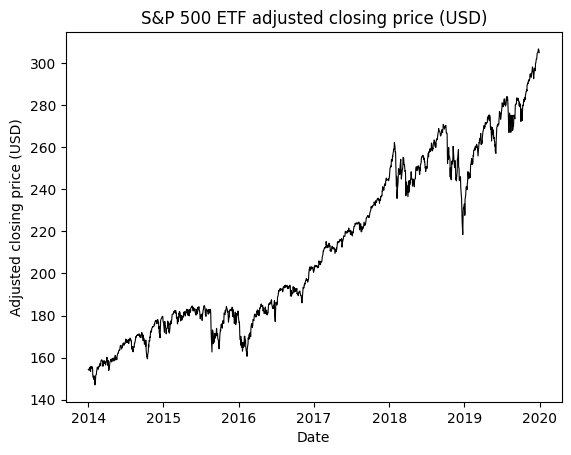

In [ ]:
# download data
ticker_symbol = 'SPY'
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

sp_500_etf_close = get_closing_price_from_yfinance(ticker_symbol, start_date, end_date)

# plot data
plt.plot(sp_500_etf_close, color='black', lw =.8)

plt.title('S&P 500 ETF adjusted closing price (USD)')
plt.xlabel('Date')
plt.ylabel('Adjusted closing price (USD)')
;

''

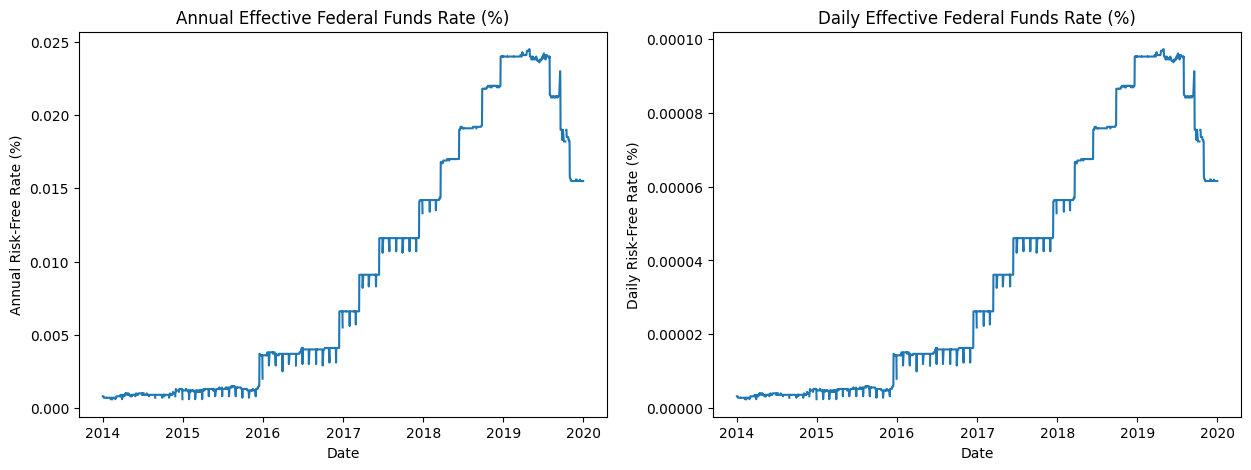

In [ ]:
# get data
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

annual_effr = get_effr_from_nyfed(start_date, end_date, daily=False)
daily_effr = get_effr_from_nyfed(start_date, end_date, daily=True)

# plot data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# annual EFFR
ax1.plot(annual_effr)
ax1.set_title('Annual Effective Federal Funds Rate (%)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Annual Risk-Free Rate (%)')

# daily EFFR
ax2.plot(daily_effr)
ax2.set_title('Daily Effective Federal Funds Rate (%)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Risk-Free Rate (%)')
;

Text(0, 0.5, 'Daily Excess Returns (%)')

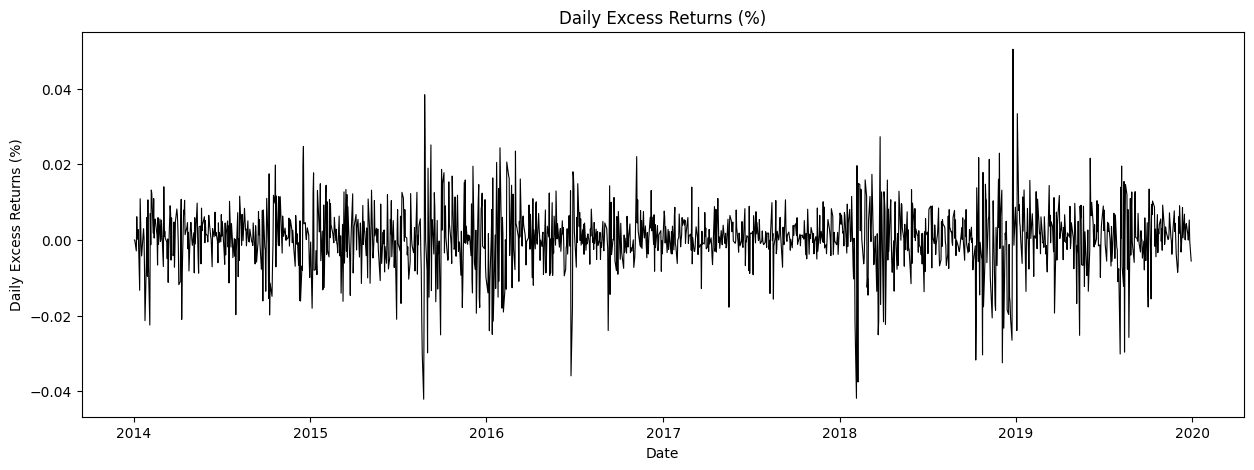

In [ ]:
# get data
daily_excess_return = get_daily_excess_return(sp_500_etf_close, daily_effr)

# get moving average
# daily_excess_return['moving_average'] = daily_excess_return['excess_returns'].rolling(25).mean()
# daily_excess_return['moving_std'] = daily_excess_return['excess_returns'].rolling(25).std()

# # get bands
# daily_excess_return['upper_band'] = daily_excess_return['moving_average'] + (daily_excess_return['moving_std'] * 1.5)
# daily_excess_return['lower_band'] = daily_excess_return['moving_average'] - (daily_excess_return['moving_std'] * 1.5)

# plot data
plt.figure(figsize=(15, 5))

plt.plot(daily_excess_return['excess_returns'], color='black', lw =.8)

# plt.plot(daily_excess_return['moving_average'], color = 'red', lw = .8)
# plt.fill_between(daily_excess_return.index, daily_excess_return['upper_band'], daily_excess_return['lower_band'], color='grey', alpha=.2)


plt.title('Daily Excess Returns (%)')
plt.xlabel('Date')
plt.ylabel('Daily Excess Returns (%)')

In [ ]:
# Proof of Concept
poc_ydata = daily_excess_return['excess_returns'].values
poc_xdata = np.arange(0, len(poc_ydata))

Text(0.5, 1.0, 'Daily Excess Returns (%)')

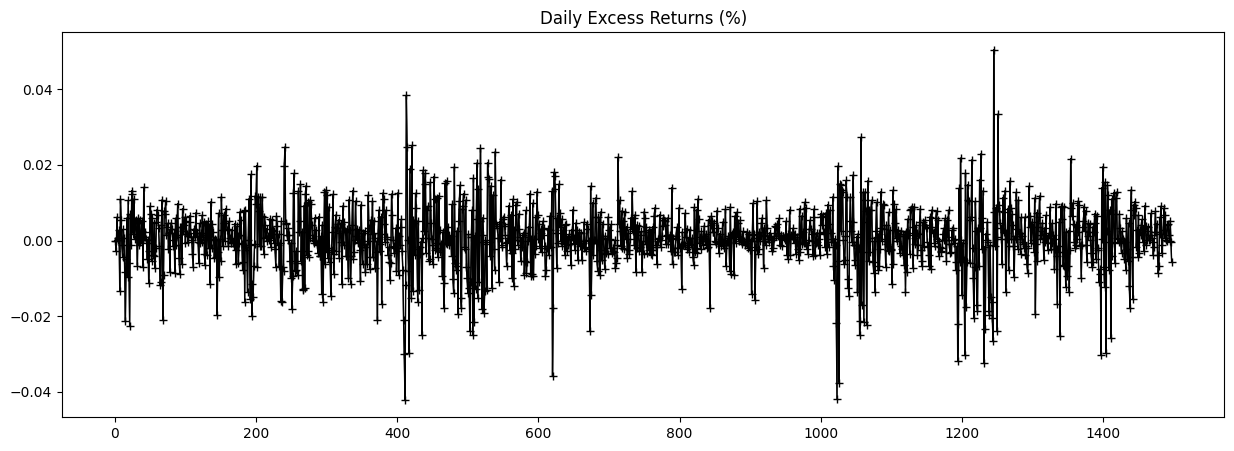

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(poc_xdata, poc_ydata, color = 'black', lw = .8, alpha = .8)
plt.plot(poc_xdata, poc_ydata, marker = '+', color = 'black', lw = 1)

plt.title('Daily Excess Returns (%)')

In [ ]:
# normalise excess daily returns
poc_ydata = (poc_ydata - poc_ydata.mean()) / poc_ydata.std()

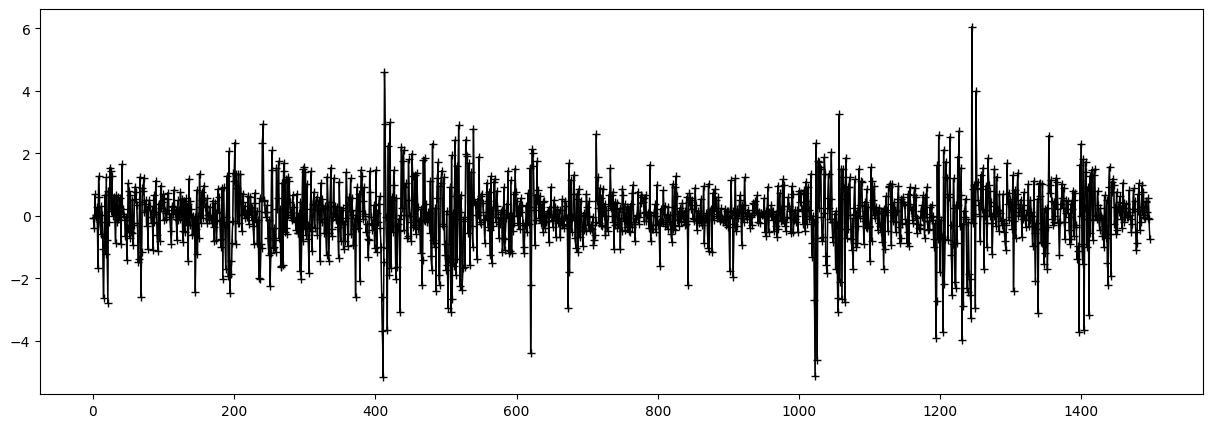

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(poc_xdata, poc_ydata, color = 'black', lw = .8, alpha = .8)
plt.plot(poc_xdata, poc_ydata, marker = '+', color = 'black', lw = 1)

In [ ]:
# define the GP

class ExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)
    
# define the likelihood
likelihood = gp.likelihoods.GaussianLikelihood()

In [ ]:
# convert to tensors
x_train = torch.from_numpy(poc_xdata[:-5]).float()
y_train = torch.from_numpy(poc_ydata[:-5]).float().squeeze()

x_test = torch.from_numpy(poc_xdata[-5:]).float()
y_test = torch.from_numpy(poc_ydata[-5:]).float().squeeze()

In [ ]:
# instantiate model
model = ExactGPModel(x_train, y_train, likelihood)

# update lengthscale and noise
model.covar_module.base_kernel.lengthscale = torch.tensor(1.5)
model.likelihood.noise = torch.tensor(0.1)

In [ ]:
# define x_test
N = len(x_train) + len(x_test)
x_range = torch.linspace(0, N, N*3)

In [ ]:
# get posterior
model.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    f_preds = model(x_range)

In [ ]:
train_threshold = 1400
x_range_mask = x_range > train_threshold

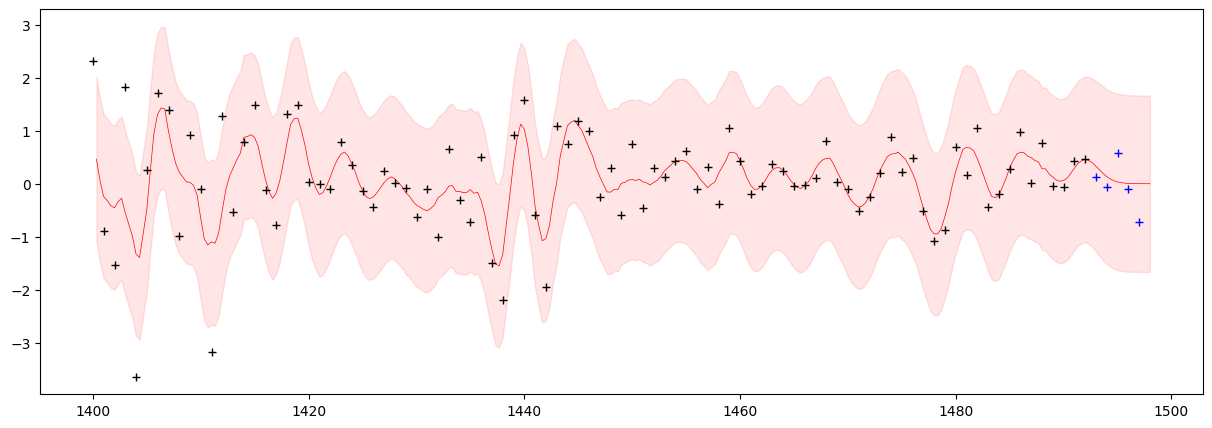

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(x_range[x_range_mask], f_preds.mean[x_range_mask], label='GP mean', color='red', lw=0.5)

# train data
plt.plot(x_train[train_threshold:], y_train[train_threshold:], '+', label='Training data', color='black')

# test data
plt.plot(x_test, y_test, '+', label='Test data', color='blue')

# for i in range(50):
#       f_samples = f_preds.rsample()
#       plt.plot(x_range, f_samples, lw=.25, alpha=.25, color='red')

upper, lower = f_preds.confidence_region()

plt.fill_between(x_range[x_range_mask], lower[x_range_mask], upper[x_range_mask], alpha=0.1, color='red')

#plt.plot(x_train, y_train, color = 'black', lw = 1, alpha = 0.5)

# plt.scatter(x_test, y_test, marker='+', label='Test data', alpha = 1, color='blue', lw=.5)
# plt.plot(x_test, y_test, alpha = 0.5, color='blue')

In [ ]:
baby_count = 0
baby_idx = []
bitch_count = 0
bitch_idx = []

for i, p in enumerate(y_train):

    if p < lower[int(p)]:
        # baby
        baby_idx.append(i)
        baby_count += 1
    if p > upper[int(p)]:
        #bitch
        bitch_idx.append(i)
        bitch_count += 1

print('I have this many babies: ', baby_count)
print('I have this many bitches: ', bitch_count)

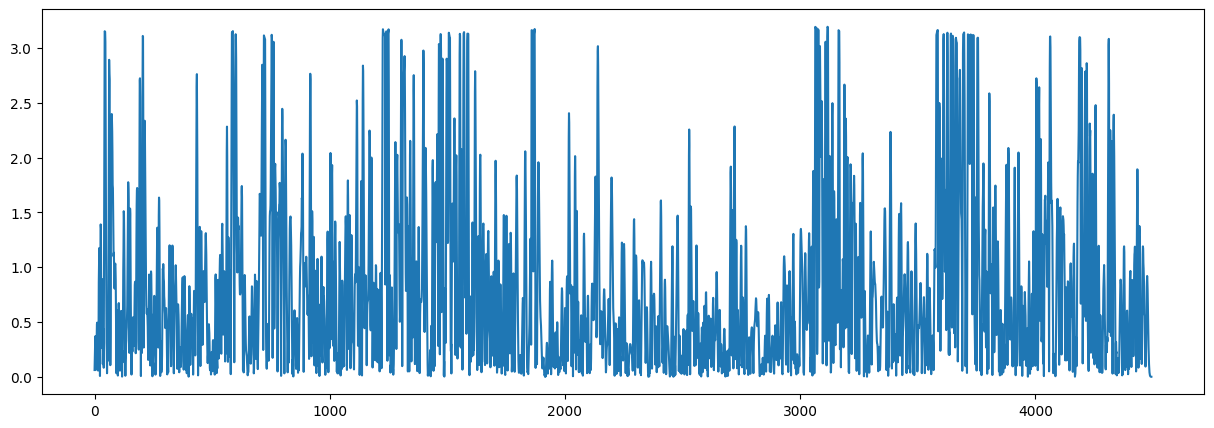

In [447]:
plt.figure(figsize=(15, 5))
plt.plot(abs(abs(upper)-abs(lower)))

I have this many babies:  2
I have this many bitches:  1493


In [428]:
baby_idx

[0, 1]

In [423]:
len(upper)

1493

ValueError: x and y must have same first dimension, but have shapes torch.Size([500]) and torch.Size([50])

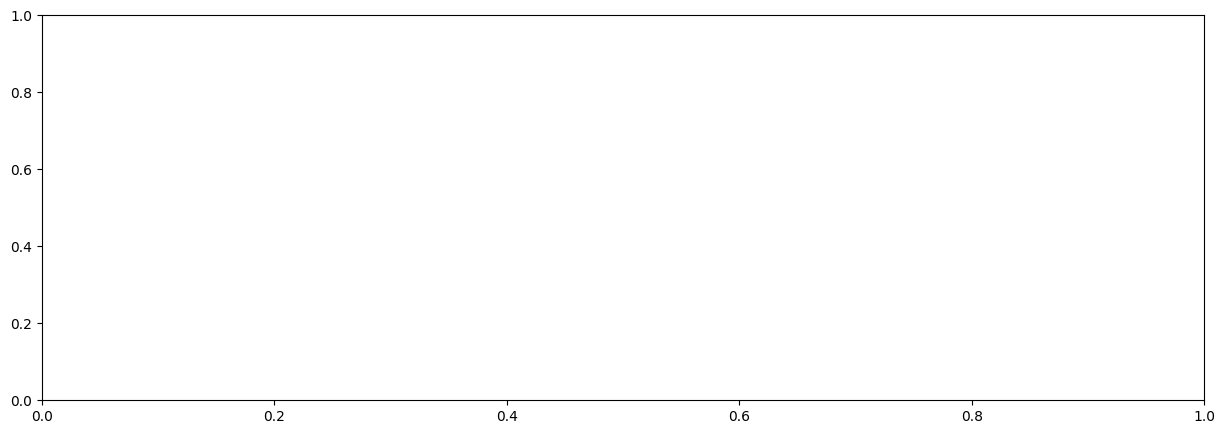

In [386]:
plt.figure(figsize=(15, 5))

plt.plot(x_range[-50*10:], f_preds.mean[-50:], label='GP mean', color='red', lw=0.5)

# train data
plt.plot(x_train[-50:], y_train[-50:], '+', label='Training data', color='black')

# test data
plt.plot(x_test[-50:], y_test[-50:], '+', label='Test data', color='blue')

# for i in range(50):
#       f_samples = f_preds.rsample()
#       plt.plot(x_range, f_samples, lw=.25, alpha=.25, color='red')

upper, lower = f_preds.confidence_region()

plt.fill_between(x_range[-50:], lower[-50:], upper[-50:], alpha=0.1, color='red')

plt.plot(x_train[-50:], y_train[-50:], color = 'black', lw = 1, alpha = 0.5)

# plt.scatter(x_test, y_test, marker='+', label='Test data', alpha = 1, color='blue', lw=.5)
# plt.plot(x_test, y_test, alpha = 0.5, color='blue')

Text(0, 0.5, 'Daily Excess Returns (%)')

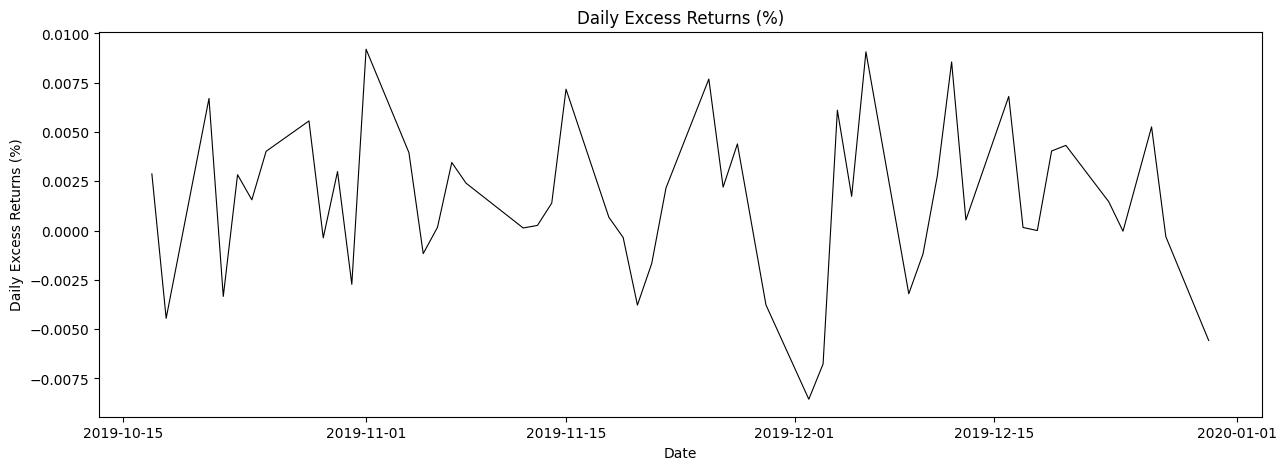

In [157]:
plt.figure(figsize=(15, 5))

plt.plot(daily_excess_return['excess_returns'][-50:], color='black', lw =.8)

# plt.plot(daily_excess_return['moving_average'], color = 'red', lw = .8)
# plt.fill_between(daily_excess_return.index, daily_excess_return['upper_band'], daily_excess_return['lower_band'], color='grey', alpha=.2)


plt.title('Daily Excess Returns (%)')
plt.xlabel('Date')
plt.ylabel('Daily Excess Returns (%)')